In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:33215 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 24 Memory: 103.08 GB


In [3]:
db = '/scratch/x77/db6174/access-om2/archive/databases/cc_database_nostress_cont_kpp.db'
session = cc.database.create_session(db)
expt = '025deg_jra55_ryf_nostress_cont_kpp'

## Introduction

This notebook aims to find a suitable parametrisation for resolved velocity shear in terms of friction velocity, coriolis frequency and a specific depth z.

In [4]:
dVsq = cc.querying.getvar(expt = expt, session = session, variable = 'dVsq', frequency = '1 daily')
ustar = cc.querying.getvar(expt = expt, session = session, variable = 'ustar', frequency = '1 daily')
hblt = cc.querying.getvar(expt = expt, session = session, variable = 'hblt', frequency = '1 daily', ncfile = 'ocean-2d-hblt-1-daily-snap-ym_1900_01.nc')
temp = cc.querying.getvar(expt = expt, session = session, variable = 'surface_temp', frequency = '1 monthly')

#### Convert both ustar and hblt to u

In [5]:
import xgcm

data = xr.merge((hblt,ustar,dVsq))
data.coords['xu_ocean'].attrs.update(axis='X')
data.coords['xt_ocean'].attrs.update(axis='X',c_grid_axis_shift=0.5)
data.coords['yu_ocean'].attrs.update(axis='Y')
data.coords['yt_ocean'].attrs.update(axis='Y',c_grid_axis_shift=0.5)
data.coords['st_ocean'].attrs.update(axis='Z')

g = xgcm.Grid(data, periodic=['X'])
u = g.interp(hblt,'X')
hblt = g.interp(u,'Y',boundary="extend")

g = xgcm.Grid(data, periodic=['X'])
u = g.interp(ustar,'X')
ustar = g.interp(u,'Y',boundary="extend")

### Plotting the interpolated and measured dVsq for a specific latitude and depth

The interpolated dVsq is given by:

$$ dVsq = \frac{z (u_{\star} + 80 u^2_{\star})}{60} e^{-\frac{10^{-4}} {u_{\star}^{-0.5}} z} $$

In [6]:
import pandas as pd

#### Example 1

In [9]:
%%time

x_val = -30
z_val = 10

# At a specific longitude, take all latitudes' hblt value
hblt_trunc = hblt.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice('1900-09-01','1900-09-02')).mean('time')

# Create a mask - this mask should be 1 if hblt at that location is deeper than z_val, otherwise the data is no use to us, since we want to properly evaluate 
# resolved velocity shear only in the KPP mixing layer
mask = hblt_trunc.where(hblt_trunc > z_val)/hblt_trunc

# Use this mask and obtain the ustar values for the specific longitude and all latitudes
ustar_val = ((ustar.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice('1900-09-01','1900-09-02')).mean('time'))*mask).values

# Outputted value of dVsq, multiplied by the mask
dVsq_trunc = (dVsq.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice('1900-09-01','1900-09-02')).mean('time').sel(st_ocean = z_val, method = 'nearest'))*mask

# Interpolated dVsq considering only those locations where the hblt is deeper than z_val.
itp_dVsq = (ustar_val + 80*ustar_val**2) * (np.exp(-1e-4*z_val/ustar_val**0.5)) * (z_val/60)
data = {'dVsq': dVsq_trunc.values,
         'Itp': itp_dVsq
        }

dVsq_stocean_df = pd.DataFrame(data = data)
print(dVsq_stocean_df.corr().values[0][1])

0.9129628140232036
CPU times: user 4.93 s, sys: 259 ms, total: 5.19 s
Wall time: 12.5 s


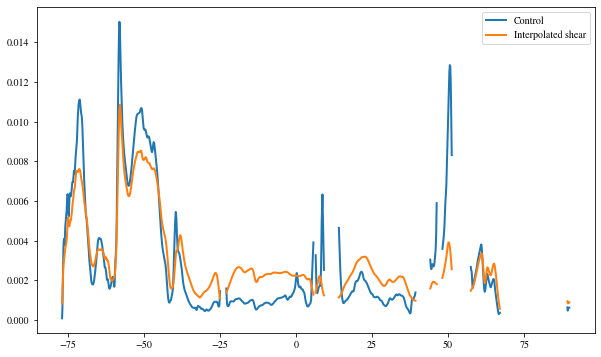

In [10]:
plt.figure(figsize = (10,6))
plt.plot(dVsq.yu_ocean, dVsq_trunc.values, label = 'Control')
plt.plot(dVsq.yu_ocean, itp_dVsq, label = 'Interpolated shear')
plt.legend()

#### Example 2

In [11]:
x_val = -170
z_val = 5

# At a specific longitude, take all latitudes' hblt value
hblt_trunc = hblt.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice('1900-06-01','1900-06-02')).mean('time')

# Create a mask - this mask should be 1 if hblt at that location is deeper than z_val, otherwise the data is no use to us, since we want to properly evaluate 
# resolved velocity shear only in the KPP mixing layer
mask = hblt_trunc.where(hblt_trunc > z_val)/hblt_trunc

# Use this mask and obtain the ustar values for the specific longitude and all latitudes
ustar_val = ((ustar.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice('1900-06-01','1900-06-02')).mean('time'))*mask).values

# Outputted value of dVsq, multiplied by the mask
dVsq_trunc = (dVsq.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice('1900-06-01','1900-06-02')).mean('time').sel(st_ocean = z_val, method = 'nearest'))*mask

# Interpolated dVsq considering only those locations where the hblt is deeper than z_val.
itp_dVsq = (1*ustar_val + 80*ustar_val**2) * (np.exp(-1e-4*z_val/ustar_val**0.5)) * (z_val/60)
data = {'dVsq': dVsq_trunc.values,
         'Itp': itp_dVsq
        }

dVsq_stocean_df = pd.DataFrame(data = data)
print(dVsq_stocean_df.corr().values[0][1])

0.45816914738134307


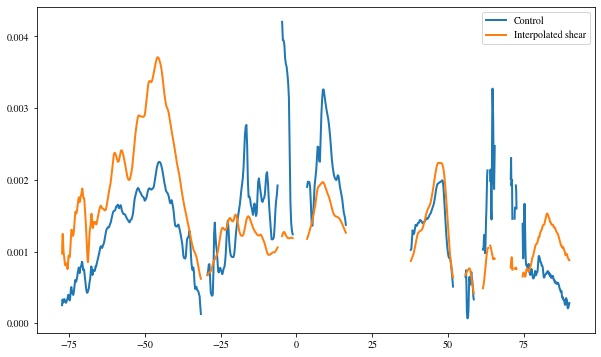

In [12]:
plt.figure(figsize = (10,6))
plt.plot(dVsq.yu_ocean, dVsq_trunc.values, label = 'Control')
plt.plot(dVsq.yu_ocean, itp_dVsq, label = 'Interpolated shear')
plt.legend()

### Dvsq for an entire year for a specific longitude and depth

#### Example 1

In [42]:
x_val = -180
z_val = 10

for i in range(0,360):
    t_start = hblt.time[int(i)]
    t_end = hblt.time[int(i+1)]
    # At a specific longitude, take all latitudes' hblt value
    hblt_trunc = hblt.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice(t_start,t_end)).mean('time')

    # Create a mask - this mask should be 1 if hblt at that location is deeper than z_val, otherwise the data is no use to us, since we want to properly evaluate 
    # resolved velocity shear only in the KPP mixing layer
    mask = hblt_trunc.where(hblt_trunc > z_val)/hblt_trunc

    # Use this mask and obtain the ustar values for the specific longitude and all latitudes
    ustar_val = ((ustar.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice(t_start,t_end)).mean('time'))*mask).values

    # Outputted value of dVsq, multiplied by the mask
    dVsq_trunc = (dVsq.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice(t_start,t_end)).mean('time').sel(st_ocean = z_val, method = 'nearest'))*mask

    # Interpolated dVsq considering only those locations where the hblt is deeper than z_val.
    #itp_dVsq = (0.05*ustar_val + 150*ustar_val**2) * (np.exp(-1e-4*z_val/ustar_val**0.5)) * (z_val/60)
    itp_dVsq = (1*ustar_val + 80*ustar_val**2) * (np.exp(-1e-4*z_val/ustar_val**0.5)) * (z_val/60)
    data = {'dVsq': dVsq_trunc.values,
             'Itp': itp_dVsq
            }

    dVsq_stocean_df = pd.DataFrame(data = data)
    corr_array[int(i)] = (dVsq_stocean_df.corr().values)[0][1]

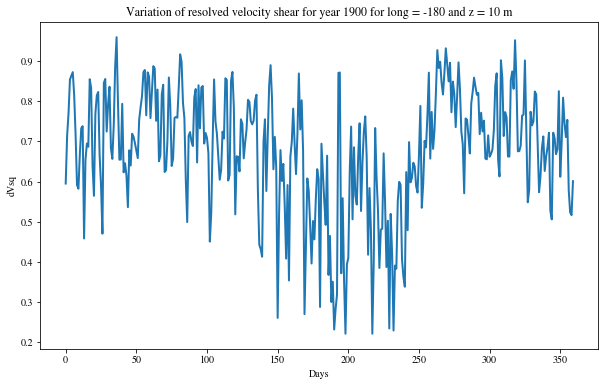

In [51]:
plt.figure(figsize = (10,6))
plt.plot(np.linspace(0,359,360),corr_array[0:360])
plt.xlabel('Days')
plt.ylabel('dVsq')
plt.title('Variation of resolved velocity shear for year 1900 for long = ' + str(x_val) + ' and z = ' + str(z_val) + ' m')
plt.savefig('Ex_param')

In [25]:
corr_array[corr_array == 0] = np.nan
np.nanmean(corr_array)

0.6323164564331333

#### Example 2

In [ ]:
x_val = -40
z_val = 10

for i in range(0,360):
    t_start = hblt.time[int(i)]
    t_end = hblt.time[int(i+1)]
    # At a specific longitude, take all latitudes' hblt value
    hblt_trunc = hblt.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice(t_start,t_end)).mean('time')

    # Create a mask - this mask should be 1 if hblt at that location is deeper than z_val, otherwise the data is no use to us, since we want to properly evaluate 
    # resolved velocity shear only in the KPP mixing layer
    mask = hblt_trunc.where(hblt_trunc > z_val)/hblt_trunc

    # Use this mask and obtain the ustar values for the specific longitude and all latitudes
    ustar_val = ((ustar.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice(t_start,t_end)).mean('time'))*mask).values

    # Outputted value of dVsq, multiplied by the mask
    dVsq_trunc = (dVsq.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice(t_start,t_end)).mean('time').sel(st_ocean = z_val, method = 'nearest'))*mask

    # Interpolated dVsq considering only those locations where the hblt is deeper than z_val.
    #itp_dVsq = (0.05*ustar_val + 150*ustar_val**2) * (np.exp(-1e-4*z_val/ustar_val**0.5)) * (z_val/60)
    itp_dVsq = (1*ustar_val + 80*ustar_val**2) * (np.exp(-1e-4*z_val/ustar_val**0.5)) * (z_val/60)
    data = {'dVsq': dVsq_trunc.values,
             'Itp': itp_dVsq
            }

    dVsq_stocean_df = pd.DataFrame(data = data)
    corr_array[int(i)] = (dVsq_stocean_df.corr().values)[0][1]

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(np.linspace(0,359,360),corr_array[0:360])
plt.xlabel('Days')
plt.ylabel('dVsq')
plt.title('Variation of resolved velocity shear for year 1900 for long = ' + str(x_val) + ' and z = ' + str(z_val) + ' m')
plt.savefig('Ex_param')

In [ ]:
corr_array[corr_array == 0] = np.nan
np.nanmean(corr_array)

### Dvsq variation for a specific latitude-longitude and depth.

In [24]:
z_array = dVsq.st_ocean.values
t_lim = 362
z_lim = 10
corr_array = np.zeros((t_lim,z_lim))

for i in range(0,t_lim):
    t_start = hblt.time[int(i)]
    t_end = hblt.time[int(i+1)]
    hblt_trunc = hblt.sel(time = slice(t_start,t_end)).mean('time')
    ustar_trunc = ustar.sel(time = slice(t_start,t_end)).mean('time')
    for j,depth in enumerate(z_array[2:2+z_lim]):
        mask = hblt_trunc.where(hblt_trunc > depth)/hblt_trunc
        ustar_trunc = ustar_trunc*mask
        dVsq_trunc = (dVsq.sel(time = slice(t_start,t_end)).mean('time').sel(st_ocean = depth, method = 'nearest'))*mask
        itp_dVsq = (1*ustar_trunc + 80*ustar_trunc**2) * (np.exp(-1e-4*depth/ustar_trunc**0.5)) * (depth/60)
        
        data =  {'dVsq': dVsq_trunc.values.flatten(),
                 'Itp': itp_dVsq.values.flatten()
                }
        dVsq_stocean_df = pd.DataFrame(data = data)
        corr_array[int(i),j] = (dVsq_stocean_df.corr().values)[0][1]
    if(i%15 == 0):
        print(i)

0
15
30
45
60
75
90
105
120
135
150
165
180
195
210
225


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


240
255
270
285
300


BrokenPipeError: [Errno 108] Cannot send after transport endpoint shutdown: b'/scratch/x77/db6174/access-om2/archive/025deg_jra55_ryf_nostress_cont_kpp/output000/ocean/ocean-2d-hblt-1-daily-snap-ym_1900_01.nc'

In [26]:
data =  {'time': dVsq.time[0:t_lim],
         'z = 6.5 m': corr_array[:,0],
         'z = 10 m': corr_array[:,1],
         'z = 14 m': corr_array[:,2],
         'z = 18.6 m': corr_array[:,3],
         'z = 24 m': corr_array[:,4],
         'z = 30.35 m': corr_array[:,5],
         'z = 37.75 m': corr_array[:,6],
         'z = 46.4 m': corr_array[:,7],
         'z = 56.48 m': corr_array[:,8],
         'z = 68.26 m': corr_array[:,9],
                }
pd.DataFrame(data = data).to_csv('R2_score.csv')

In [39]:
np.mean(corr_array[0:310,0])

0.7649831116066136

## Plots for each z for the entire year

Text(0.5, 1.0, 'Variation of parametrised resolved velocity shear for year 1900 for z = 68.26 m')

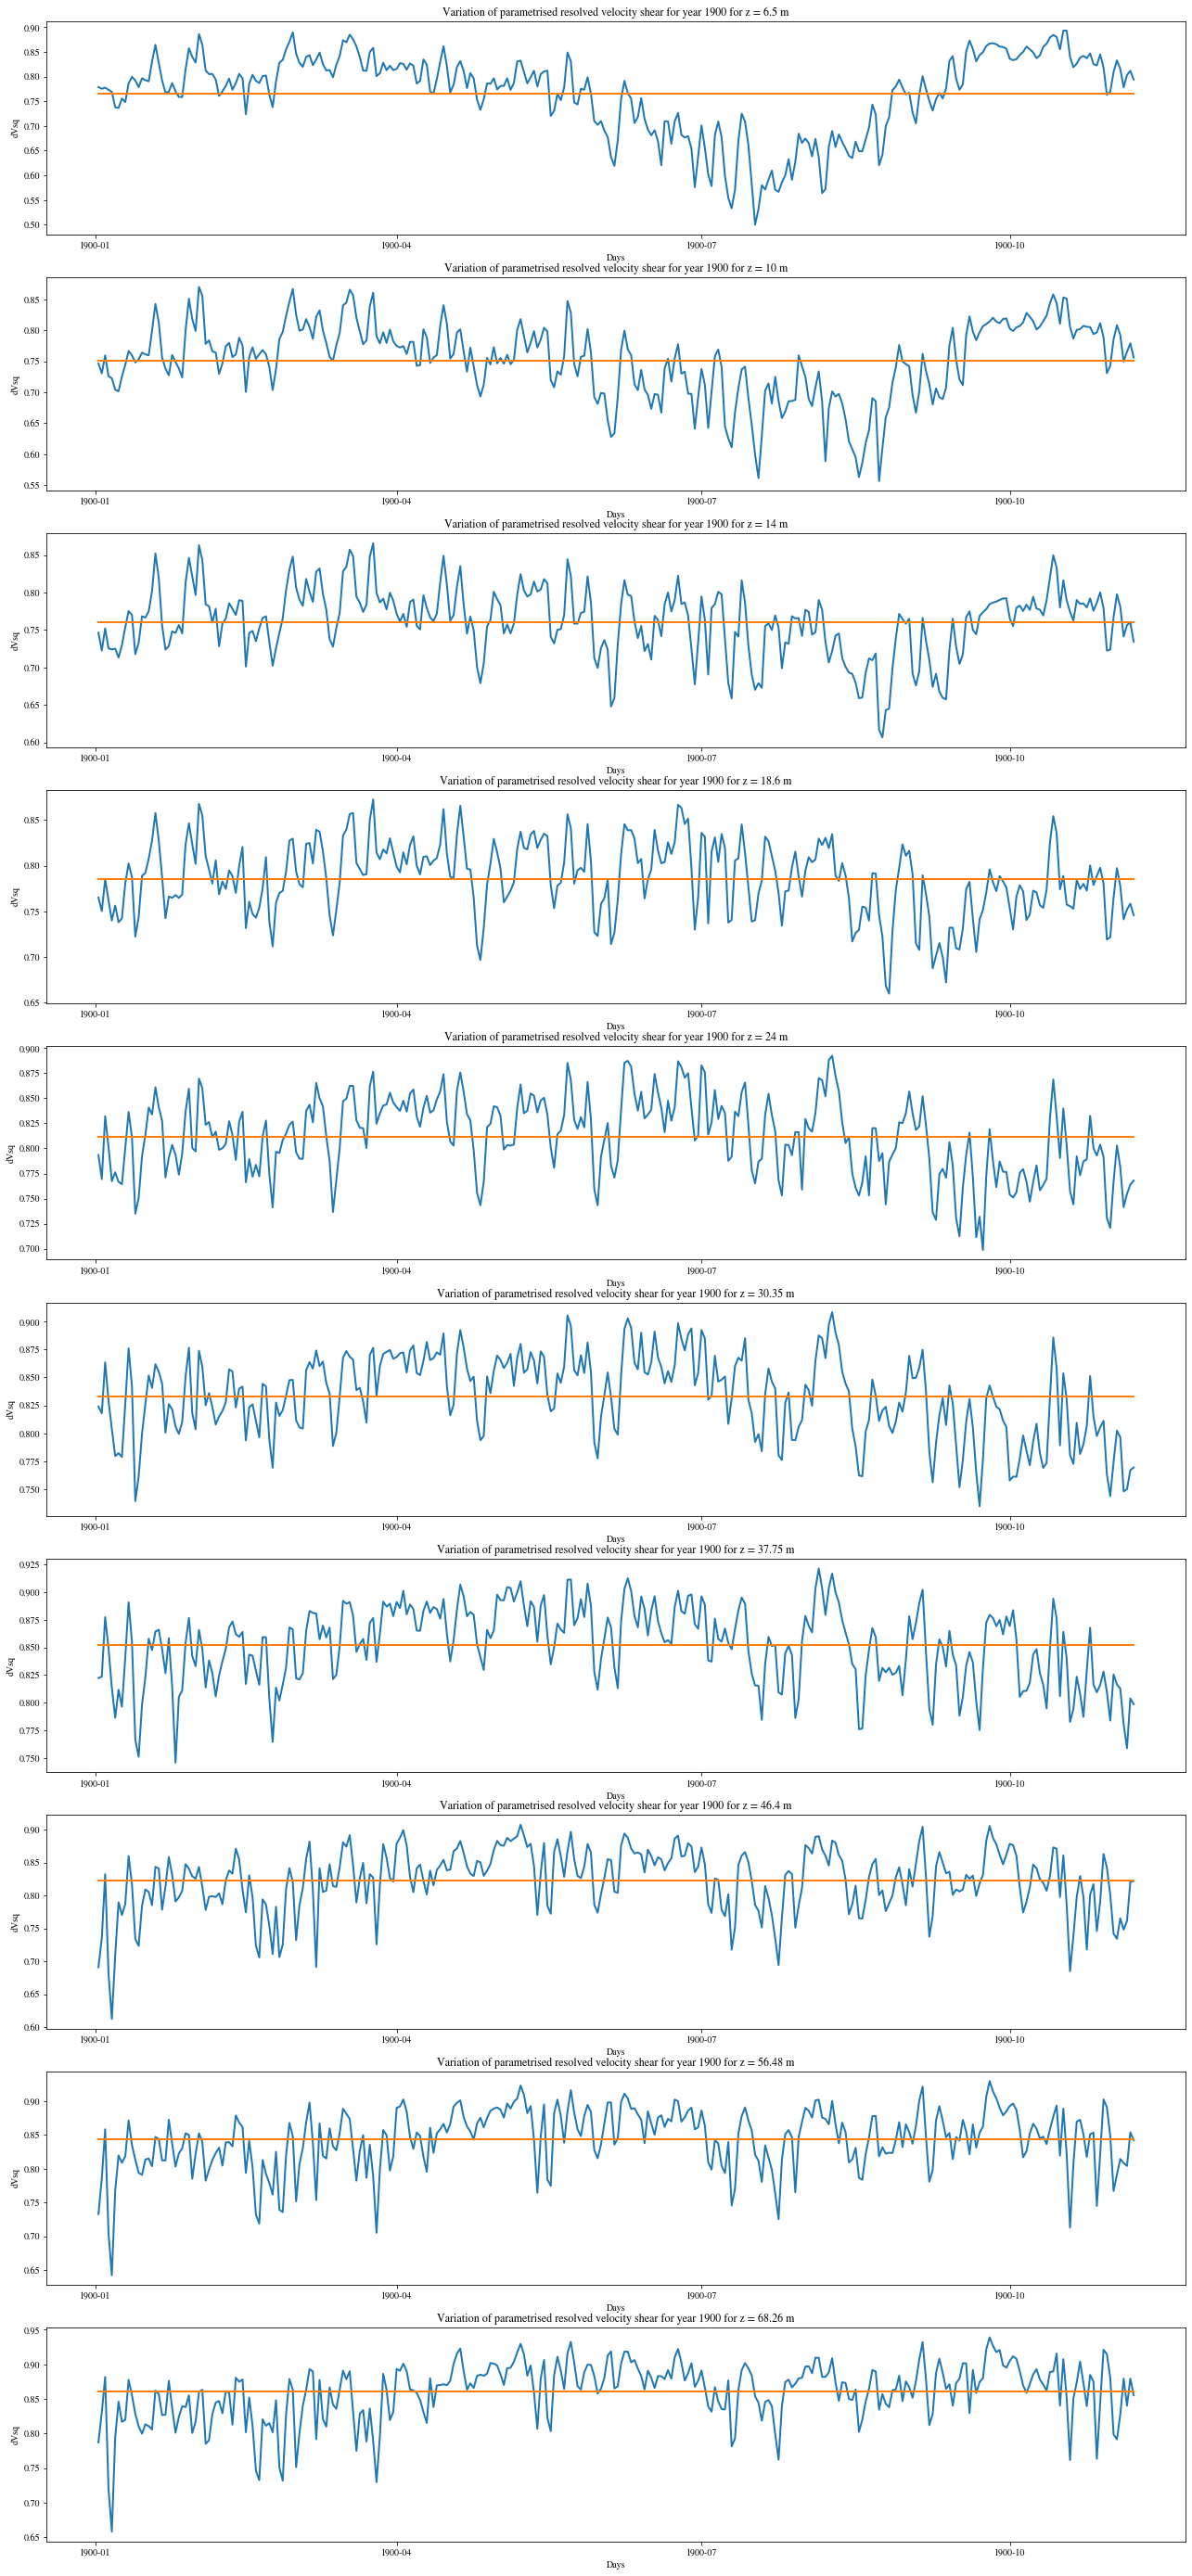

In [42]:
# Note that the plots are from 1st Jan to 10th Nov because of the error which stopped the calculations after that.

plt.figure(figsize=(22,50))

plt.subplot(10,1,1)
plt.plot(dVsq.time[0:310], corr_array[0:310,0], label = 'Variation')
plt.plot(dVsq.time[0:310], np.mean(corr_array[0:310,0]) * np.ones(310), label = 'Mean')
plt.xlabel('Days')
plt.ylabel('dVsq')
plt.title('Variation of parametrised resolved velocity shear for year 1900 for z = 6.5 m')

plt.subplot(10,1,2)
plt.plot(dVsq.time[0:310],corr_array[0:310,1], label = 'Variation')
plt.plot(dVsq.time[0:310], np.mean(corr_array[0:310,1]) * np.ones(310), label = 'Mean')
plt.xlabel('Days')
plt.ylabel('dVsq')
plt.title('Variation of parametrised resolved velocity shear for year 1900 for z = 10 m')

plt.subplot(10,1,3)
plt.plot(dVsq.time[0:310],corr_array[0:310,2], label = 'Variation')
plt.plot(dVsq.time[0:310], np.mean(corr_array[0:310,2]) * np.ones(310), label = 'Mean')
plt.xlabel('Days')
plt.ylabel('dVsq')
plt.title('Variation of parametrised resolved velocity shear for year 1900 for z = 14 m')

plt.subplot(10,1,4)
plt.plot(dVsq.time[0:310],corr_array[0:310,3], label = 'Variation')
plt.plot(dVsq.time[0:310], np.mean(corr_array[0:310,3]) * np.ones(310), label = 'Mean')
plt.xlabel('Days')
plt.ylabel('dVsq')
plt.title('Variation of parametrised resolved velocity shear for year 1900 for z = 18.6 m')

plt.subplot(10,1,5)
plt.plot(dVsq.time[0:310],corr_array[0:310,4], label = 'Variation')
plt.plot(dVsq.time[0:310], np.mean(corr_array[0:310,4]) * np.ones(310), label = 'Mean')
plt.xlabel('Days')
plt.ylabel('dVsq')
plt.title('Variation of parametrised resolved velocity shear for year 1900 for z = 24 m')

plt.subplot(10,1,6)
plt.plot(dVsq.time[0:310],corr_array[0:310,5], label = 'Variation')
plt.plot(dVsq.time[0:310], np.mean(corr_array[0:310,5]) * np.ones(310), label = 'Mean')
plt.xlabel('Days')
plt.ylabel('dVsq')
plt.title('Variation of parametrised resolved velocity shear for year 1900 for z = 30.35 m')

plt.subplot(10,1,7)
plt.plot(dVsq.time[0:310],corr_array[0:310,6], label = 'Variation')
plt.plot(dVsq.time[0:310], np.mean(corr_array[0:310,6]) * np.ones(310), label = 'Mean')
plt.xlabel('Days')
plt.ylabel('dVsq')
plt.title('Variation of parametrised resolved velocity shear for year 1900 for z = 37.75 m')

plt.subplot(10,1,8)
plt.plot(dVsq.time[0:310],corr_array[0:310,7], label = 'Variation')
plt.plot(dVsq.time[0:310], np.mean(corr_array[0:310,7]) * np.ones(310), label = 'Mean')
plt.xlabel('Days')
plt.ylabel('dVsq')
plt.title('Variation of parametrised resolved velocity shear for year 1900 for z = 46.4 m')

plt.subplot(10,1,9)
plt.plot(dVsq.time[0:310],corr_array[0:310,8], label = 'Variation')
plt.plot(dVsq.time[0:310], np.mean(corr_array[0:310,8]) * np.ones(310), label = 'Mean')
plt.xlabel('Days')
plt.ylabel('dVsq')
plt.title('Variation of parametrised resolved velocity shear for year 1900 for z = 56.48 m')

plt.subplot(10,1,10)
plt.plot(dVsq.time[0:310],corr_array[0:310,9], label = 'Variation')
plt.plot(dVsq.time[0:310], np.mean(corr_array[0:310,9]) * np.ones(310), label = 'Mean')
plt.xlabel('Days')
plt.ylabel('dVsq')
plt.title('Variation of parametrised resolved velocity shear for year 1900 for z = 68.26 m')